In [55]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, compute_log_likelihood 

path = "fall_2021_prior_samples:1633297030/"
files = [f for f in listdir(path) if isfile(join(path, f))]



In [2]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points


In [7]:
len(sampled_points)

158

In [51]:
import numpy as np
logliks = {}
highest_loglik = -10000
highest_f = None
for f in sampled_points:
    logliks[f] = compute_log_likelihood(aggregated_trajs[f], eps=0)
    if logliks[f] > highest_loglik:
        highest_loglik = logliks[f]
        highest_f = f

/home/jmc678/covid_data/group-testing/notebooks/vax_sims/fall_2021_projection_utils.py:33: RuntimeWarning: divide by zero encountered in log
  loglik += np.log(poisson.pmf(true_positives, simulated_positives) + eps)


In [52]:
highest_f

'point_47'

In [54]:
for param_name, param_val in zip(UNCERTAINTY_PARAMS, sampled_points['point_47']):
    print(param_name, param_val)

vax_susc_mult 0.5370941919429542
vax_transmission_mult 0.11333684430606117
contacts_per_day_mult 1.7251393196724418
outside_infection_rate_mult 2.55842038903454
cases_isolated_per_contact_trace 0.7288543844706954
initial_ID_prevalence 0.003353401873121036


In [4]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

In [5]:
UNCERTAINTY_PARAMS

['vax_susc_mult',
 'vax_transmission_mult',
 'contacts_per_day_mult',
 'outside_infection_rate_mult',
 'cases_isolated_per_contact_trace',
 'initial_ID_prevalence']

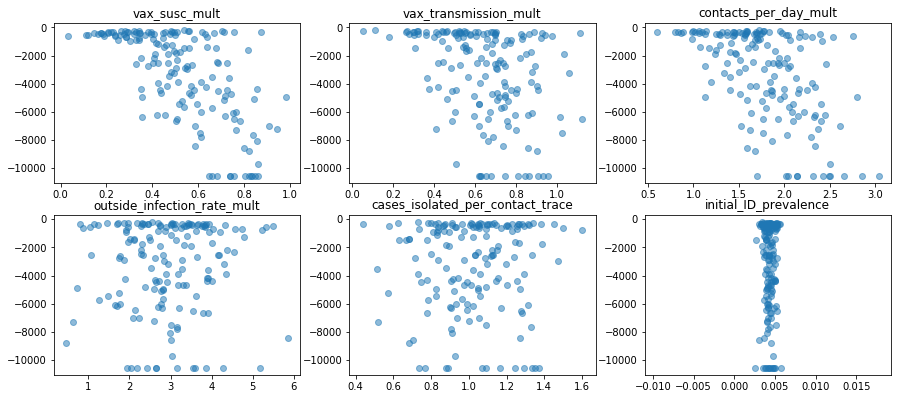

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


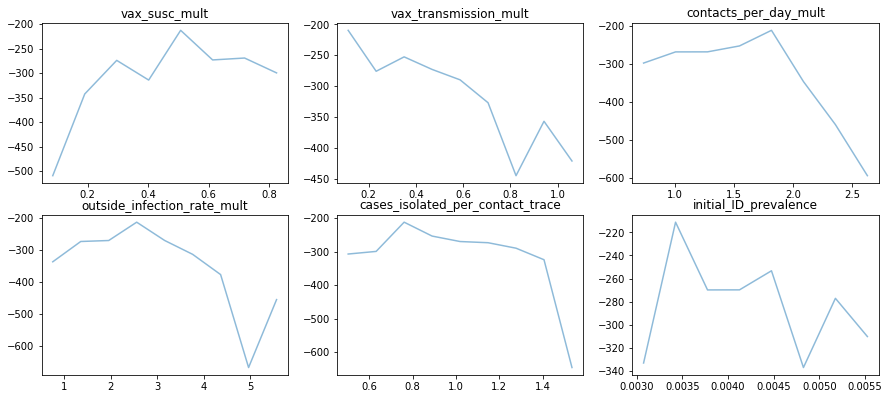

In [33]:
def estimate_marginal_dist(param_vals, logliks):
    bin_boundaries = np.linspace(min(param_vals), max(param_vals), num=10)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        if bin_end_val == max(param_vals):
            bin_end_val += 1
        likelihoods = [np.exp(loglik) for (param_val, loglik) in zip(param_vals, logliks)
                      if param_val >= bin_start_val and param_val < bin_end_val and 
                      loglik != float('-inf')]
        
        avg_lik = np.log(np.mean(likelihoods))
        bin_likelihoods.append(avg_lik)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(param_vals[param], param_logliks[param])
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [23]:
compute_log_likelihood(aggregated_trajs['point_0'])

/home/jmc678/covid_data/group-testing/notebooks/vax_sims/fall_2021_projection_utils.py:33: RuntimeWarning: divide by zero encountered in log
  loglik += np.log(poisson.pmf(true_positives, simulated_positives + eps))


-inf

In [25]:
actual_traj = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1,0,0]
mean_traj = np.mean(aggregated_trajs['point_0'], axis=0)

In [27]:
idx = 0
while idx < len(actual_traj):
    if idx == 0:
        new_positives = mean_traj[idx]
    else:
        new_positives = mean_traj[idx] - mean_traj[idx - 1]
    print("day = {}".format(idx))
    print("new_positives = {}, actual_positives = {}".format(new_positives, actual_traj[idx]))
    pmf = poisson.pmf(actual_traj[idx], new_positives + 1e-5)
    print("pmf = {}".format(pmf))
    print("loglik = {}\n\n".format(np.log(pmf)))
    idx += 1
    

day = 0
new_positives = 2.79, actual_positives = 2
pmf = 0.23905375872327553
loglik = -1.4310668204474624


day = 1
new_positives = 15.030000000000001, actual_positives = 2
pmf = 3.3530353915292966e-05
loglik = -10.303059442358634


day = 2
new_positives = 24.83, actual_positives = 11
pmf = 0.0009121238095402791
loglik = -6.999734821029097


day = 3
new_positives = 31.690000000000005, actual_positives = 23
pmf = 0.0221780700307094
loglik = -3.8086513147904206


day = 4
new_positives = 43.42999999999999, actual_positives = 42
pmf = 0.059990865258096694
loglik = -2.8135629740489776


day = 5
new_positives = 64.96, actual_positives = 57
pmf = 0.03171825270412822
loglik = -3.450862968722376


day = 6
new_positives = 92.65, actual_positives = 55
pmf = 6.845924050712531e-06
loglik = -11.891857111883269


day = 7
new_positives = 132.41000000000003, actual_positives = 39
pmf = 8.717463698397128e-22
loglik = -48.49154371053173


day = 8
new_positives = 181.11999999999995, actual_positives = 31


/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [29]:
np.log(poisson.pmf(0, 1e-5))

-1.0000000000005732e-05

In [15]:
np.mean(aggregated_trajs['point_0'], axis=0)

array([2.790000e+00, 1.782000e+01, 4.265000e+01, 7.434000e+01,
       1.177700e+02, 1.827300e+02, 2.753800e+02, 4.077900e+02,
       5.889100e+02, 8.414700e+02, 1.185430e+03, 1.646290e+03,
       2.245240e+03, 2.985190e+03, 3.816520e+03, 4.555870e+03,
       5.149470e+03, 5.683750e+03, 6.258400e+03, 6.866890e+03,
       7.476710e+03, 8.072020e+03, 8.625240e+03, 9.113520e+03,
       9.544110e+03, 9.935490e+03, 1.031855e+04, 1.070380e+04,
       1.109531e+04, 1.150436e+04, 1.193309e+04, 1.236998e+04,
       1.280038e+04, 1.321005e+04, 1.359349e+04, 1.392059e+04,
       1.418589e+04, 1.437932e+04, 1.452019e+04, 1.461664e+04,
       1.468397e+04, 1.473451e+04, 1.477108e+04, 1.479880e+04,
       1.481933e+04, 1.483779e+04, 1.485367e+04, 1.486954e+04,
       1.488524e+04, 1.490063e+04, 1.491503e+04])

In [19]:
from scipy.stats import poisson
import numpy as np

np.log(poisson.pmf(0, 1e-5))

-1.0000000000005732e-05

In [21]:
np.log(0)

/home/jmc678/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf